# Lab3 - Training Deep Convolutional Neural Network
- Kanchayapond Saejoong, 62070505201
- Wayu Ragwongsiri, 62070505215

Name your file to (first 2 student ID digit)_(last 4 student ID digit)*4.ipynb

## Lab Instruction 

In this lab, you will learn to train a deep convolutional neural network using Keras library with Tensorflow backend. We will use  Cat vs Dog dataset.

See https://www.kaggle.com/c/dogs-vs-cats/data


## Your Turn! Dog or Cat Application 

Now, it time to put everything together and develop and Cat vs Dog classifier model. Assume that you and your company want to get more attraction on your product by launching a new product that can classify whether it is a dog or a cat. You have decide that you want a precision more than 90 - 95% in order to launch to product.

You have a cat and dog dataset contain total of 25000 images, 12500 for cat and other half for a dog.

After successfully develop this model, you can try to play with it to see how it perform. (You can upload your selfies image to see you are a dog or a cat)

Some note before start a project:
1. You have to load a data into a project using any method 
**suggest**
   

```
 !wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
 !unzip -qq Cat_Dog_data.zip
```


2. You have to plan on how you will split a data. (or no need for suggest method)
3. You have to preprocess your data before feed into a network. For example, cropping, padding, etc.
4. You can come up with any model or use pre-train model. It depend on you!

You have two week for this project so that you can compete with your competitor app! Now, create a new Jupyter notebook and start building a model!

In [1]:
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend as K
from keras.preprocessing import image
from keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import np_utils
from keras.layers.convolutional import  MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import os
import cv2
from numpy.random import seed
from pathlib import Path
import seaborn as sns
%matplotlib inline

In [2]:
# %load _utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K

# Test
def print_hello():
    print('Hello')

# define a function to plot the result from training step
def show_result(history): 
    
    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['acc'][-1])
    print('Last validation accuracy: %s'%history.history['val_acc'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):
    
    # Calculate result
    result = model.evaluate(features,labels,verbose=False)
    
    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
    labels = labels.argmax(axis=1)
    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))
    
    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28, channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')
    
    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))
            
# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
        
def deprocess_image(img):
    
    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1
    
    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)
    
    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')
    
    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]
    
    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)
    
    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])
    
    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

### feed layer name. ie, 'conv_1'
def visualize_filter(model,layer_name, size= 64, margin = 5):

    # Empty black image to store results
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    # iterate over the row of result grid
    for i in range(8):
        # Iterate over the column of the result grid
        for j in range(8):
            # Generates the pattern for filter i + (j*8) in layer_name
            filter_img = generate_pattern(model, layer_name, i + (j*8), size=size)
            
            # Puts the result in the square (i,j) of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)  

In [3]:
from keras.preprocessing.image import ImageDataGenerator

In [4]:
!wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
!unzip -qq Cat_Dog_data.zip

--2022-04-29 13:51:17--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.171.8
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.171.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘Cat_Dog_data.zip’

Cat_Dog_data.zip    100%[===================>] 553.60M  71.7MB/s    in 11s     

2022-04-29 13:51:28 (52.6 MB/s) - ‘Cat_Dog_data.zip’ saved [580495262/580495262]



###Creat directory dataframe

In [5]:
train_image_dir = Path('../content/Cat_Dog_data/train')
test_image_dir = Path('../content/Cat_Dog_data/test')

In [6]:
#create list of directory name of file and map it to create labels
train_filepaths = list(train_image_dir.glob(r'**/*.jpg'))
train_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], train_filepaths))
test_filepaths = list(test_image_dir.glob(r'**/*.jpg'))
test_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], test_filepaths))

In [7]:
#create pd dataframe 
train_filepaths_df = pd.Series(train_filepaths , name = 'train_filepath').astype(str)
train_labels_df = pd.Series(train_labels, name = 'train_label')

test_filepaths_df = pd.Series(test_filepaths, name = 'test_filepath').astype(str)
test_labels_df = pd.Series(test_labels, name = 'test_label')

train_df = pd.concat([train_filepaths_df, train_labels_df], axis = 1)
test_df = pd.concat([test_filepaths_df, test_labels_df], axis = 1)

In [8]:
train_df.head()

,train_filepath,train_label
0,../content/Cat_Dog_data/train/cat/cat.326.jpg,cat
1,../content/Cat_Dog_data/train/cat/cat.12392.jpg,cat
2,../content/Cat_Dog_data/train/cat/cat.4329.jpg,cat
3,../content/Cat_Dog_data/train/cat/cat.7526.jpg,cat
4,../content/Cat_Dog_data/train/cat/cat.6814.jpg,cat


In [9]:
test_df.head()

,test_filepath,test_label
0,../content/Cat_Dog_data/test/cat/cat.5835.jpg,cat
1,../content/Cat_Dog_data/test/cat/cat.8930.jpg,cat
2,../content/Cat_Dog_data/test/cat/cat.10609.jpg,cat
3,../content/Cat_Dog_data/test/cat/cat.5846.jpg,cat
4,../content/Cat_Dog_data/test/cat/cat.541.jpg,cat


###Load Dataset & Preprocessing

In [ ]:
#create preset of image generator
train_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    validation_split = 0.1,
    horizontal_flip = True
)

test_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
)

In [10]:
#load data by flow_from_dataframe
train_ds = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'train_filepath',
    y_col = 'train_label',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 32,
    shuffle = True,
    seed = 123,
    subset = 'training'
)

val_ds = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'train_filepath',
    y_col = 'train_label',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 32,
    shuffle = True,
    seed = 123,
    subset = 'validation'
)

test_ds = test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'test_filepath',
    y_col = 'test_label',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 32,
    shuffle = False,
)

NameError: ignored

###Own CNN

####Build a convolutional neural network
Baseline Optimize x224 rgb

In [ ]:
IMG_WIDTH, IMG_HEIGHT, CHANNEL = 224, 224, 3

cnn = models.Sequential()
cnn.add(layers.Conv2D(filters=16,
                      kernel_size=(3,3),
                      padding='same',
                      activation = 'relu',
                      kernel_initializer='he_normal',
                      input_shape=(IMG_WIDTH,IMG_HEIGHT,CHANNEL,),
                      name = 'conv_1',
                     ))
cnn.add(layers.Conv2D(filters=16,
                      kernel_size=(3,3),
                      padding='same',
                      activation = 'relu',
                      kernel_initializer='he_normal',
                      input_shape=(IMG_WIDTH,IMG_HEIGHT,CHANNEL,),
                      name = 'conv_2',
                     ))
cnn.add(layers.MaxPooling2D(2,2,name='max_pool_1'))
cnn.add(layers.Conv2D(filters=32,
                      kernel_size=(3,3),
                      padding='same',
                      kernel_initializer='he_normal',
                      activation = 'relu',
                      name = 'conv_3',
                     ))
cnn.add(layers.Conv2D(filters=32,
                      kernel_size=(3,3),
                      padding='same',
                      kernel_initializer='he_normal',
                      activation = 'relu',
                      name = 'conv_4',
                     ))
cnn.add(layers.MaxPooling2D(2,2,name='max_pool_2'))
cnn.add(layers.Dropout(0.25,name='dropout_1'))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(128,activation='relu',
                     kernel_initializer='he_normal',
                     name='fully_connect_1'
                    ))
cnn.add(layers.Dropout(0.5,name='dropout_2'))
cnn.add(layers.Dense(1,activation='sigmoid',
                     kernel_initializer='he_normal',
                     name='output'
                    ))
cnn.compile(optimizer='adam',
           loss = 'binary_crossentropy',
           metrics=['acc'])
cnn.save('baseline_optimize.h5')
cnn.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 conv_2 (Conv2D)             (None, 224, 224, 16)      2320      
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 112, 112, 16)      0         
                                                                 
 conv_3 (Conv2D)             (None, 112, 112, 32)      4640      
                                                                 
 conv_4 (Conv2D)             (None, 112, 112, 32)      9248      
                                                                 
 max_pool_2 (MaxPooling2D)   (None, 56, 56, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 32)      

####Trainig CNN Model

Epoch 1/10
633/633 [==============================] - 722s 1s/step - loss: 0.7470 - acc: 0.6018 - val_loss: 0.6861 - val_acc: 0.6022 - lr: 0.0010
Epoch 2/10
633/633 [==============================] - 719s 1s/step - loss: 0.6063 - acc: 0.6640 - val_loss: 0.5915 - val_acc: 0.7951 - lr: 0.0010
Epoch 3/10
633/633 [==============================] - 721s 1s/step - loss: 0.5735 - acc: 0.7009 - val_loss: 0.7016 - val_acc: 0.6240 - lr: 0.0010
Epoch 4/10
633/633 [==============================] - 716s 1s/step - loss: 0.5422 - acc: 0.7276 - val_loss: 0.5133 - val_acc: 0.7920 - lr: 0.0010
Epoch 5/10
633/633 [==============================] - 712s 1s/step - loss: 0.5289 - acc: 0.7356 - val_loss: 0.6720 - val_acc: 0.6467 - lr: 0.0010
Epoch 6/10
633/633 [==============================] - 710s 1s/step - loss: 0.5133 - acc: 0.7508 - val_loss: 0.7659 - val_acc: 0.6209 - lr: 0.0010
Epoch 7/10
633/633 [==============================] - 709s 1s/step - loss: 0.4981 - acc: 0.7596 - val_loss: 0.6310 - val_acc

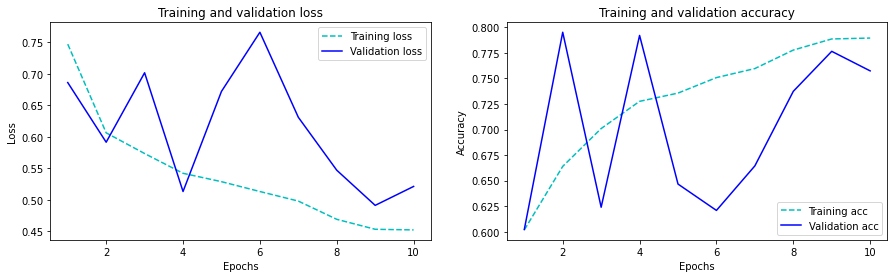

In [ ]:
history = cnn.fit(
    train_ds, 
    batch_size=32,
    epochs=10,
    validation_data=(val_ds),
    callbacks = [keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 5,
        restore_best_weights = True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_loss',
        patience = 3
    )]
)
cnn.save('baseline_optimize_x224_itr10.h5')
show_result(history)

In [ ]:
history = cnn.fit(
    train_ds, 
    batch_size=32,
    epochs=10,
    validation_data=(val_ds),
    callbacks = [keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 5,
        restore_best_weights = True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_loss',
        patience = 3
    )]
)
cnn.save('baseline_optimize_x224_itr20.h5')

Epoch 1/10
633/633 [==============================] - 710s 1s/step - loss: 0.4446 - acc: 0.7961 - val_loss: 0.5003 - val_acc: 0.7684 - lr: 1.0000e-04
Epoch 2/10
633/633 [==============================] - 709s 1s/step - loss: 0.4394 - acc: 0.7978 - val_loss: 0.4965 - val_acc: 0.7738 - lr: 1.0000e-04
Epoch 3/10
633/633 [==============================] - 708s 1s/step - loss: 0.4385 - acc: 0.8010 - val_loss: 0.5415 - val_acc: 0.7480 - lr: 1.0000e-04
Epoch 4/10
633/633 [==============================] - 734s 1s/step - loss: 0.4311 - acc: 0.8025 - val_loss: 0.5045 - val_acc: 0.7702 - lr: 1.0000e-04
Epoch 5/10
633/633 [==============================] - 727s 1s/step - loss: 0.4279 - acc: 0.8064 - val_loss: 0.4198 - val_acc: 0.8249 - lr: 1.0000e-04
Epoch 6/10
633/633 [==============================] - 718s 1s/step - loss: 0.4249 - acc: 0.8063 - val_loss: 0.4719 - val_acc: 0.7809 - lr: 1.0000e-04
Epoch 7/10
633/633 [==============================] - 714s 1s/step - loss: 0.4209 - acc: 0.8120 - va

Last train accuracy: 0.8138271570205688
Last validation accuracy: 0.8013333082199097


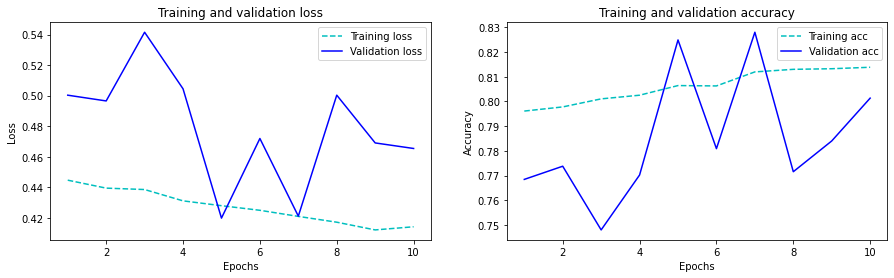

In [ ]:
show_result(history)

####Evaluate CNN Model

In [ ]:
result = cnn.evaluate(test_ds, verbose=0)

print("Test loss: {:.5f}".format(result[0]))
print("Test accuracy: {:.2f}".format(result[1]))

Test loss: 0.42349
Test accuracy: 0.81


In [ ]:
prediction = (cnn.predict(test_ds) >= 0.5).astype(np.int)
confmx = confusion_matrix(test_ds.labels, prediction, labels = [0, 1])

clsfyrep = classification_report(test_ds.labels, prediction, labels = [0, 1], target_names = ['cat', 'dog'])

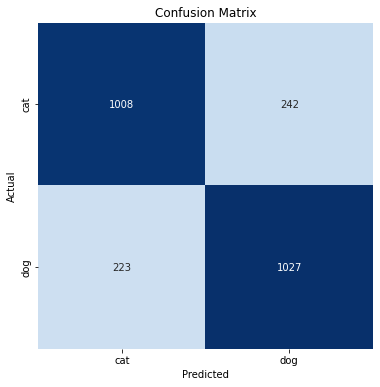


Classification Report:
--------------------
               precision    recall  f1-score   support

         cat       0.82      0.81      0.81      1250
         dog       0.81      0.82      0.82      1250

    accuracy                           0.81      2500
   macro avg       0.81      0.81      0.81      2500
weighted avg       0.81      0.81      0.81      2500



In [ ]:
plt.figure(figsize = (6, 6))
sns.heatmap(confmx, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=['cat','dog'])
plt.yticks(ticks=[0.5, 1.5], labels=['cat','dog'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n--------------------\n", clsfyrep)

###Transfer Learning

####Build a transfer learning CNN Model
Use transfer learning: InceptionResNetV2

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

In [ ]:
def def_model():
  model = InceptionResNetV2(
      include_top=False, 
      input_shape=(224, 224, 3)
  )
  for layer in model.layers:
  		layer.trainable = False
  flat1 = Flatten()(model.layers[-1].output)
  full_conn = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  output = Dense(1, activation='sigmoid')(full_conn)
	# define new model
  model = Model(inputs=model.inputs, outputs=output)
	# compile model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  model.save('InceptionResNetV2.h5')
  model.summary()
  return model

In [ ]:
irnv2 = def_model()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_812 (Conv2D)            (None, 111, 111, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_812 (Batch  (None, 111, 111, 32  96         ['conv2d_812[0][0]']             
 Normalization)                 )                                                           

####Training a transfer learning CNN

In [ ]:
history3 = irnv2.fit(
    train_ds, 
    batch_size=32,
    epochs=10,
    validation_data=(val_ds),
    callbacks = [keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 5,
        restore_best_weights = True
    )]
)
irnv2.save('InceptionResNetV2_x224_itr10.h5')

Epoch 1/10
633/633 [==============================] - 1343s 2s/step - loss: 0.1701 - acc: 0.9787 - val_loss: 0.0462 - val_acc: 0.9880
Epoch 2/10
633/633 [==============================] - 1317s 2s/step - loss: 0.0394 - acc: 0.9860 - val_loss: 0.1022 - val_acc: 0.9600
Epoch 3/10
633/633 [==============================] - 1313s 2s/step - loss: 0.0346 - acc: 0.9885 - val_loss: 0.0386 - val_acc: 0.9871
Epoch 4/10
633/633 [==============================] - 1313s 2s/step - loss: 0.0315 - acc: 0.9893 - val_loss: 0.0350 - val_acc: 0.9884
Epoch 5/10
633/633 [==============================] - 1299s 2s/step - loss: 0.0347 - acc: 0.9886 - val_loss: 0.0754 - val_acc: 0.9764
Epoch 6/10
633/633 [==============================] - 1299s 2s/step - loss: 0.0301 - acc: 0.9894 - val_loss: 0.0892 - val_acc: 0.9729
Epoch 7/10
633/633 [==============================] - 1297s 2s/step - loss: 0.0321 - acc: 0.9894 - val_loss: 0.0697 - val_acc: 0.9836
Epoch 8/10
633/633 [==============================] - 1297s 2s

Last train accuracy: 0.9900246858596802
Last validation accuracy: 0.981333315372467


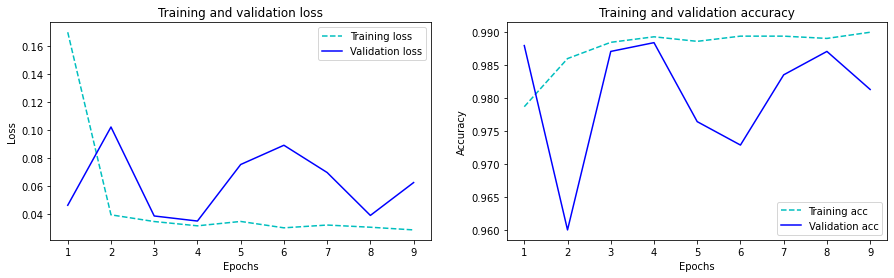

In [ ]:
show_result(history3)

####Evaluate transfer learning CNN

In [ ]:
result = irnv2.evaluate(test_ds, verbose=0)

print("Test loss: {:.5f}".format(result[0]))
print("Test accuracy: {:.2f}".format(result[1]))

Test loss: 0.02843
Test accuracy: 0.99


In [ ]:
prediction = (irnv2.predict(test_ds) >= 0.5).astype(np.int)
confmx = confusion_matrix(test_ds.labels, prediction, labels = [0, 1])

clsfyrep = classification_report(test_ds.labels, prediction, labels = [0, 1], target_names = ['cat', 'dog'])

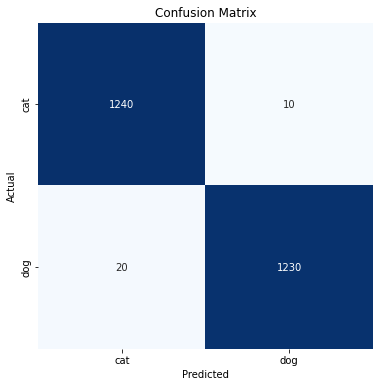


Classification Report:
--------------------
               precision    recall  f1-score   support

         cat       0.98      0.99      0.99      1250
         dog       0.99      0.98      0.99      1250

    accuracy                           0.99      2500
   macro avg       0.99      0.99      0.99      2500
weighted avg       0.99      0.99      0.99      2500



In [ ]:
plt.figure(figsize = (6, 6))
sns.heatmap(confmx, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=['cat','dog'])
plt.yticks(ticks=[0.5, 1.5], labels=['cat','dog'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n--------------------\n", clsfyrep)

##Challenge

###Set challenge directory

In [ ]:
from skimage.io import imread
from skimage.io import imshow

In [ ]:
cha_img_cat = os.listdir('/content/Challenge/cat')
cha_img_cat.append('cat')
cha_img_dog = os.listdir('/content/Challenge/dog')
cha_img_dog.append('dog')
cha_img_oth = os.listdir('/content/Challenge/other')
cha_img_oth.append('oth')

In [ ]:
def chaImgToList(cha_img_list):
  img_list = []
  last_img = len(cha_img_list)-1
  flag = ''
  if cha_img_list[last_img] == 'cat':
    flag = cha_img_list[last_img]
  elif cha_img_list[last_img] == 'dog':
    flag = cha_img_list[last_img]
  else:
    flag = cha_img_list[last_img]
  for i in range(len(cha_img_list)-1):
    img_list.append('/content/Challenge/'+cha_img_list[last_img]+'/'+cha_img_list[i])
    print(img_list[i])
  return img_list

In [ ]:
cha_cat_dir = chaImgToList(cha_img_cat)
len(cha_cat_dir)

/content/Challenge/cat/IMG_6432.JPG
/content/Challenge/cat/IMG_6376.JPG
/content/Challenge/cat/IMG_6631.JPG
/content/Challenge/cat/IMG_6582.JPG
/content/Challenge/cat/IMG_6630.JPG
/content/Challenge/cat/IMG_6581.JPG
/content/Challenge/cat/IMG_6602.JPG
/content/Challenge/cat/IMG_6621.JPG
/content/Challenge/cat/IMG_6459.JPG
/content/Challenge/cat/IMG_6407.JPG
/content/Challenge/cat/DCF4D241-2F4C-4C39-9A70-921F399A5C27.jpg
/content/Challenge/cat/IMG_6580.JPG
/content/Challenge/cat/IMG_6948.JPG
/content/Challenge/cat/IMG_6583.JPG
/content/Challenge/cat/IMG_6413.JPG
/content/Challenge/cat/IMG_6338.JPG


16

In [ ]:
cha_dog_dir = chaImgToList(cha_img_dog)
len(cha_dog_dir)

/content/Challenge/dog/IMG_8683.jpg
/content/Challenge/dog/IMG_6960.JPG


2

In [ ]:
cha_oth_dir = chaImgToList(cha_img_oth)
len(cha_oth_dir)

/content/Challenge/oth/IMG_6956.JPG
/content/Challenge/oth/IMG_6339.JPG
/content/Challenge/oth/IMG_6634.JPG
/content/Challenge/oth/IMG_6197.PNG
/content/Challenge/oth/IMG_6359.JPG


5

###Create Function to test

In [ ]:
def predict_img(img_dir, model):
  image_file = image.load_img(img_dir)
  plt.imshow(image_file)

  img_file = image.load_img(img_dir, target_size=(224, 224))
  img_array = image.img_to_array(img_file)
  img_batch = np.expand_dims(img_array, axis = 0)

  if model == 'cnn':
    prediction = cnn.predict(img_batch)
  elif model == 'irnv2':
    prediction = irnv2.predict(img_batch)
  img_name_list = img_dir.split('/')
  img_name = img_name_list[len(img_name_list)-1]

  print('Image file name:', img_name)   
  if prediction[0][0] >= 0.5: 
    print('\nPrediction of this image: Cat\n')
  else:
    print('\nPrediction of this image: Dog\n')

###Challenge Testing

####Cat

Image file name: IMG_6432.JPG

Prediction of this image: Cat



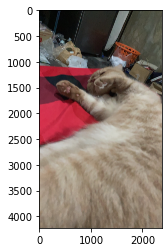

In [ ]:
predict_img(cha_cat_dir[0],'cnn')

Image file name: IMG_6432.JPG

Prediction of this image: Cat



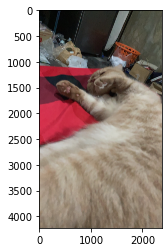

In [ ]:
predict_img(cha_cat_dir[0],'irnv2')

Image file name: IMG_6581.JPG

Prediction of this image: Dog



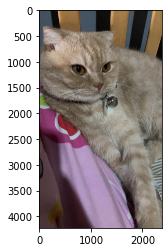

In [ ]:
predict_img(cha_cat_dir[5],'cnn')

Image file name: IMG_6581.JPG

Prediction of this image: Cat



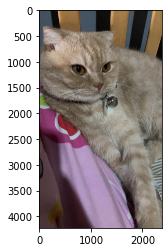

In [ ]:
predict_img(cha_cat_dir[5],'irnv2')

Image file name: IMG_6407.JPG

Prediction of this image: Cat



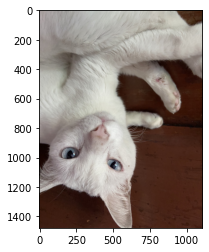

In [ ]:
predict_img(cha_cat_dir[9],'cnn')

Image file name: IMG_6407.JPG

Prediction of this image: Cat



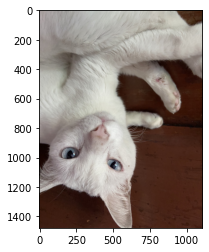

In [ ]:
predict_img(cha_cat_dir[9],'irnv2')

Image file name: IMG_6338.JPG

Prediction of this image: Cat



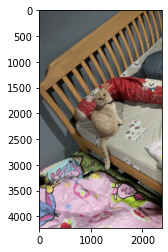

In [ ]:
predict_img(cha_cat_dir[15],'cnn')

Image file name: IMG_6338.JPG

Prediction of this image: Dog



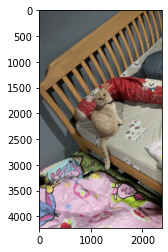

In [ ]:
predict_img(cha_cat_dir[15],'irnv2')

####Dog

Image file name: IMG_8683.jpg

Prediction of this image: Dog



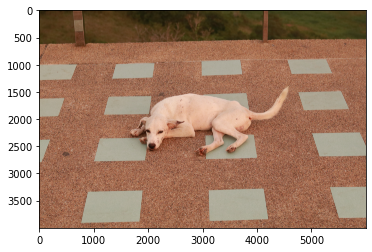

In [ ]:
predict_img(cha_dog_dir[0],'cnn')

Image file name: IMG_8683.jpg

Prediction of this image: Dog



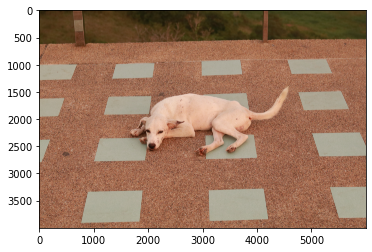

In [ ]:
predict_img(cha_dog_dir[0],'irnv2')

Image file name: IMG_6960.JPG

Prediction of this image: Cat



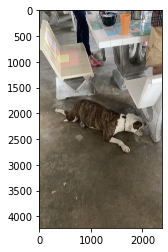

In [ ]:
predict_img(cha_dog_dir[1],'cnn')

Image file name: IMG_6960.JPG

Prediction of this image: Dog



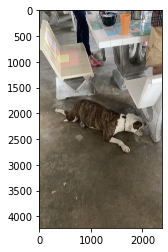

In [ ]:
predict_img(cha_dog_dir[1],'irnv2')

####Other (such as Human or memes)

Image file name: IMG_6956.JPG

Prediction of this image: Cat



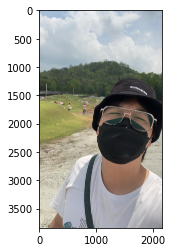

In [ ]:
predict_img(cha_oth_dir[0],'cnn')

Image file name: IMG_6956.JPG

Prediction of this image: Dog



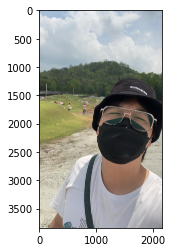

In [ ]:
predict_img(cha_oth_dir[0],'irnv2')

Image file name: IMG_6339.JPG

Prediction of this image: Cat



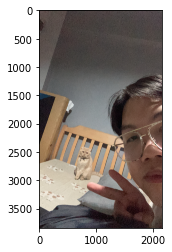

In [ ]:
predict_img(cha_oth_dir[1],'cnn')

Image file name: IMG_6339.JPG

Prediction of this image: Dog



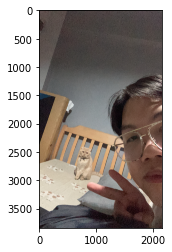

In [ ]:
predict_img(cha_oth_dir[1],'irnv2')

Image file name: IMG_6634.JPG

Prediction of this image: Cat



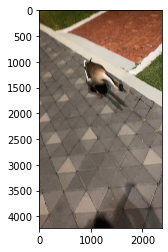

In [ ]:
predict_img(cha_oth_dir[2],'cnn')

Image file name: IMG_6634.JPG

Prediction of this image: Cat



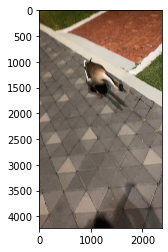

In [ ]:
predict_img(cha_oth_dir[2],'irnv2')

Image file name: IMG_6197.PNG

Prediction of this image: Cat



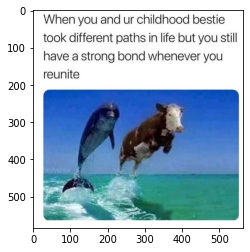

In [ ]:
predict_img(cha_oth_dir[3],'cnn')

Image file name: IMG_6197.PNG

Prediction of this image: Dog



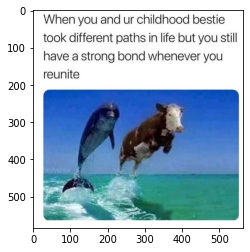

In [ ]:
predict_img(cha_oth_dir[3],'irnv2')

Image file name: IMG_6359.JPG

Prediction of this image: Dog



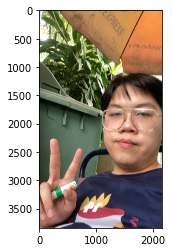

In [ ]:
predict_img(cha_oth_dir[4],'cnn')

Image file name: IMG_6359.JPG

Prediction of this image: Cat



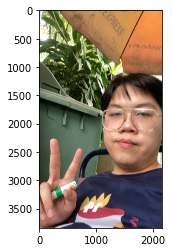

In [ ]:
predict_img(cha_oth_dir[4],'irnv2')